In [1]:
# Load data
from sklearn.datasets import load_wine
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

d = load_wine()
x = d['data']
y = d['target']

y[y==2] = 1

# x = np.random.randn(100,3)*1+[3,5,7]
# x = np.concatenate([x, np.random.randn(100,3)*1+[-6,5, -7]])
# y=np.concatenate([np.zeros(100),np.ones(100)])
y[y==0]=-1

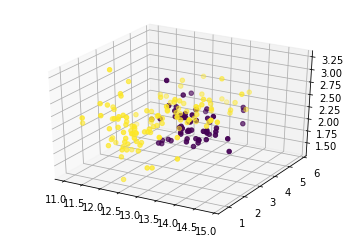

In [2]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x[:,0], x[:,1], x[:,2], c=y)

# Using LDA to reduce the dimensions
This uses LDA, Linear Discrementant Analysis, for supervised dimensinality reduction

In [3]:
import scipy as sp

class lda:
    def __init__(self):
        pass
    
    def transform(self, x, nc=1):
        return x.dot(self.eigen_vectors[:,0:nc])
        
    def fit(self, x, y):
        m = np.mean(x, axis=0) # Overall mean
        c = np.unique(y) # Class labels
        sb = np.zeros((x.shape[1], x.shape[1])) # Between class scatter
        sw = np.zeros((x.shape[1], x.shape[1])) # Within class scatter

        for i in c:
            inst = x[np.where(y==i)[0],:] # Instances in the class i
            m_i = np.mean(inst, axis=0) # Mean of the instances in the class i
            n_i = inst.shape[0] # Number of instances in the class i
            mc = m-m_i # To be used to calculate the distance between the center of data and center of the class i
            mc = mc.reshape((-1,1))
            sb += n_i*mc.dot(mc.T) # 
            cov_i = (inst-m_i).T.dot(inst-m_i)        
            sw += cov_i

#         eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(sw).dot(sb))
        
        eigen_values, eigen_vectors = sp.linalg.eig(sb, sw)
        
        indx = np.argsort(-abs(eigen_values))
        eigen_values = eigen_values[indx]
        eigen_vectors = eigen_vectors[:,indx].real
        v = abs(eigen_values)/sum(abs(eigen_values))
        self.eigen_values = eigen_values
        self.eigen_vectors = eigen_vectors
        self.variance = v

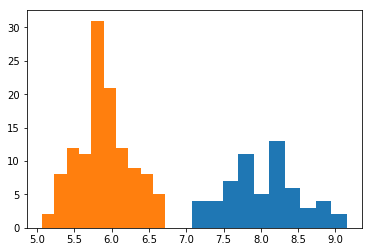

Described variance per LD [1.00000000e+00 3.45981678e-15 2.66705252e-15 7.85090569e-16
 6.65986254e-16 3.55281169e-16 1.51720760e-16 1.34903180e-16
 6.73379464e-17 5.32463138e-17 3.55428345e-17 2.29408782e-17
 8.73426375e-18]


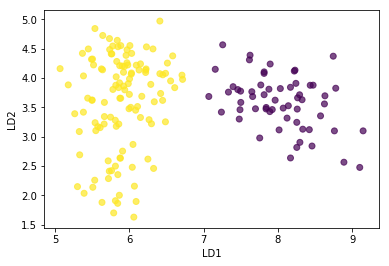

In [4]:
l = lda()
l.fit(x, y)

x_lda = l.transform(x, 1)
for i in np.unique(y):
    plt.hist(x_lda[np.where(y==i)])
plt.show()

x_lda = l.transform(x, 2)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(x_lda[:,0], x_lda[:,1], c=y, alpha=0.7)
print('Described variance per LD', l.variance)

# Using SVM to reduce the dimensions
This uses SVM for supervised dimensinality reduction

In [9]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, ElasticNet

class svm_dr:
    def __init__(self):
        pass
    
    def transform(self, x, nc=1):
        r = np.zeros((x.shape[0], nc))
        for i in range(nc):  
            x=x-self.means[i,:]
            r[:, i] = x.dot(self.reduction_vector[:,i])+self.intercepts[i]
            
        return r
        
    def fit(self, x, y, nc=1, C=0.5):
        self.reduction_vector = np.zeros((x.shape[1], nc))
        self.intercepts = np.zeros(nc)
        self.means = np.zeros((nc, x.shape[1]))
        
        x1 = x    
        
        for i in range(nc):  
            self.means[i,:] = np.mean(x1, axis=0)
            x1 = x1-np.mean(x1, axis=0)
            
#             print('max(||X||)=', np.max(np.linalg.norm(x1, axis=1)))
            m = LinearSVC(C=C)    
#             m = LinearSVC(penalty='l1', dual=False)
    
            m.fit(x1, y)
            omega = m.coef_
            
            self.reduction_vector[:,i] = omega
            self.intercepts[i] = m.intercept_
            
            omega = omega/np.linalg.norm(omega)
            x1 = x1 - x1.dot(omega.T).dot(omega)  
            

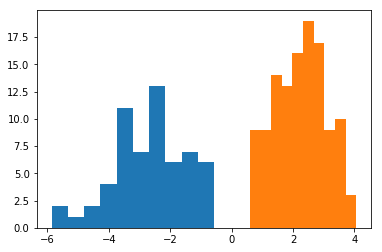

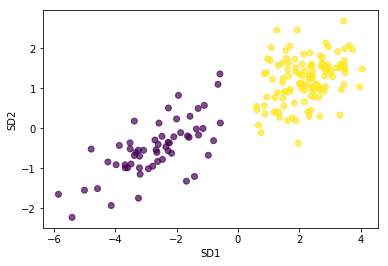

In [10]:
l = svm_dr()
l.fit(x, y, nc=3, C=0.5)

x_svm = l.transform(x, 1)
for i in np.unique(y):
    plt.hist(x_svm[np.where(y==i)])
plt.show()

x_svm = l.transform(x, 2)
plt.xlabel('SD1')
plt.ylabel('SD2')
plt.scatter(x_svm[:,0], x_svm[:,1], c=y, alpha=0.7)

In [11]:
import pandas as pd
pd.DataFrame(l.reduction_vector)

,0,1,2
0,-0.833424,0.000000,-0.867976
1,-0.235026,-0.223862,-0.475178
2,-1.611465,1.537985,0.000000
3,0.200964,-0.009802,0.190559
4,0.001011,-0.003139,0.000950
5,0.000000,0.000000,0.000000
6,-0.570331,-0.323620,-0.902595
7,0.000000,-0.248212,0.000000
8,0.000000,0.272655,0.151635
9,0.000000,0.047061,0.045400


In [13]:
l.reduction_vector.T.dot(l.reduction_vector)

array([[ 3.99979327, -2.18738063,  1.72891246],
       [-2.18738063,  2.66935493,  0.50625277],
       [ 1.72891246,  0.50625277,  2.25916701]])

In [103]:
x_svm = (x-np.mean(x, axis=0)).dot(l.reduction_vector[:,4])+l.intercepts[4]
for i in np.unique(y):
    plt.hist(x_svm[np.where(y==i)])
plt.show()

IndexError: index 4 is out of bounds for axis 1 with size 3

In [31]:
o = l.reduction_vector[:,0].reshape((-1, 1))
x1 = x-(x.dot(o).dot(o.T))

In [34]:
x-x.dot(o.dot(o.T))

array([[ 3.25479896,  5.04802131,  6.83094377],
       [ 2.66433495,  6.65823223,  6.79643584],
       [ 2.29253736,  5.48069783,  6.63406957],
       [ 3.34122366,  3.55149365,  7.88408656],
       [ 4.00780739,  7.16560414,  6.31419537],
       [ 0.47098819,  5.11136337,  7.43071937],
       [ 2.15747914,  5.87293585,  7.03679221],
       [ 1.84761537,  4.80196794,  4.12607416],
       [ 2.8943672 ,  4.75380981,  6.87088633],
       [ 1.8828031 ,  5.19253544,  6.25984016],
       [ 2.23898049,  4.10525774,  6.81248221],
       [ 3.28194165,  4.3981367 ,  8.21996302],
       [ 2.21095748,  4.70687795,  6.25151301],
       [ 2.94730399,  5.97060913,  6.08734592],
       [ 4.4321185 ,  4.04559253,  5.48176166],
       [ 3.14490692,  5.02864348,  5.70922327],
       [ 3.86718306,  4.73768213,  5.69817929],
       [ 3.33067751,  3.73980943,  8.1522295 ],
       [ 3.34783425,  5.91061229,  6.21148071],
       [ 3.58525308,  5.32941482,  7.19876236],
       [ 4.39485856,  5.61175286,  7.242